# Welcome to Match Results Predict Program!

In [1]:
import ipywidgets as widgets

file = open("Images/Stadium.jpg", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=900,
    height=100,
)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x02\x1cICC_PROFILE\x00\x0…

In [2]:
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import re
import os
import matplotlib as np
from matplotlib import pyplot as plt
from numpy import random
#from scipy.stats import uniform
import seaborn as sns
%matplotlib inline
from datetime import date
from scipy.stats import poisson,skellam
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import time


In [3]:
def get_url_content(url):
    url = "https://www.transfermarkt.com" + url
    response = requests.get(url, headers={'User-Agent': 'Custom'})
    return BeautifulSoup(response.content, 'html.parser')
    

In [4]:
#### Choosing The Date Of The Match To Predict #####

try:
    %store -r chosen_date
    print("chosen_date is: ", chosen_date)
except:
    print("It means that you skipped the DatePicker Program, so please insert your match date now")
    day = str(input("Please insert a valid day (for example, 06):  "))
    month = str(input("Please insert a valid month (for example, 07):  "))
    year = str(input("Please insert a valid full year (for example, 2021):  "))
    chosen_date = year+'-'+month+'-'+day
    print("you chose the date: ", chosen_date)

chosen_date is:  2021-07-17


In [5]:
url = "https://www.transfermarkt.com/live/index?datum=" + chosen_date

try:
    response = requests.get(url, headers={'User-Agent': 'Custom'})
    game_list_url_content = BeautifulSoup(response.content, 'html.parser')
except:
    print("Something's wrong. You didn't insert a valid date parameters.")
    exit(1) 


games = []

for each_category in game_list_url_content.findAll("div", class_="kategorie"):
    category = each_category.find("a")
    each_livescore = each_category.find_next_sibling("table", class_="livescore")
    for each_game in each_livescore.findAll("tr", class_="begegnungZeile"):
        status = each_game.find("td", class_="zeit hide-for-small")
        home_team = each_game.find("td", class_="verein-heim")
        away_team = each_game.find("td", class_="verein-gast")
        match_stats_link = each_game.find("td", class_="ergebnis").find("a", href=True)
        if match_stats_link == None : ## games_df.link.fillna("Can't Receive Game Data", inplace=True)
            link = "-"
        else :
            link = "https://www.transfermarkt.com" + match_stats_link.get('href')
            
        temp = []
        temp.append(category.get_text(strip=True))
        temp.append(status.get_text(strip=True))
        temp.append(home_team.get_text(strip=True))
        temp.append(away_team.get_text(strip=True))
        temp.append(link)
        games.append(tuple(temp))

In [6]:
games_df = pd.DataFrame(games, columns = ['Competition', 'Status', 'Home Team Name', 'Away Team Name', 'link'])
games_df_styler = games_df.style.set_properties(**{'text-align': 'left'})
games_df_styler = games_df_styler.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

games_df.to_csv(os.path.join(r'Matchdays' , str(chosen_date)+'.csv'))
#games_df.to_csv(os.path.join(r'Matchdays' , str(date.today())))

display(games_df_styler)


,Competition,Status,Home Team Name,Away Team Name,link
0,Campeonato Brasileiro Série A,matchday 12,São Paulo,Fortaleza,https://www.transfermarkt.com/spielbericht/index/spielbericht/3583831
1,Campeonato Brasileiro Série A,matchday 12,Ceará SC,Athletico-PR,https://www.transfermarkt.com/spielbericht/index/spielbericht/3583834
2,Campeonato Brasileiro Série B,matchday 12,Confiança-SE,Guarani,https://www.transfermarkt.com/spielbericht/index/spielbericht/3584117
3,Campeonato Brasileiro Série B,matchday 12,Sampaio Corrêa,Coritiba FC,https://www.transfermarkt.com/spielbericht/index/spielbericht/3584118
4,Campeonato Brasileiro Série B,matchday 12,Brasil-RS,EC Vitória,https://www.transfermarkt.com/spielbericht/index/spielbericht/3584113
5,Campeonato Brasileiro Série B,matchday 12,Goiás EC,Londrina-PR,https://www.transfermarkt.com/spielbericht/index/spielbericht/3584110
6,Campeonato Brasileiro Série B,matchday 12,Cruzeiro,Avaí FC,https://www.transfermarkt.com/spielbericht/index/spielbericht/3584112
7,Campeonato Brasileiro Série B,matchday 12,Ponte Preta,Remo,https://www.transfermarkt.com/spielbericht/index/spielbericht/3584111
8,Campeonato Brasileiro Série C,Group Stage,EC São José,Oeste FC-SP,https://www.transfermarkt.com/spielbericht/index/spielbericht/3602794
9,Campeonato Brasileiro Série C,Group Stage,Mirassol-SP,Criciúma EC,https://www.transfermarkt.com/spielbericht/index/spielbericht/3602795


In [7]:
#### Choosing Match To Predict #####

#match_stats_url = []
#match_stats_url = [games[-1] for games in games]  # list of all the urls of the games

game_number = int(input("Please choose match number to predict:  "))


match_to_predict_url = games[game_number][4]

#match_to_predict_url =  match_stats_url[game_number]

while match_to_predict_url == '-':
    game_number = int(input("No data about this match. Please choose another match to continue:  "))
    match_to_predict_url = games[game_number][4]
    
home_team = games[game_number][2]
away_team = games[game_number][3]

print('You chose to predict the result of', home_team, 'vs', away_team)

Please choose match number to predict:  0
You chose to predict the result of São Paulo vs Fortaleza


<AxesSubplot:ylabel='Last Meetings Winner'>

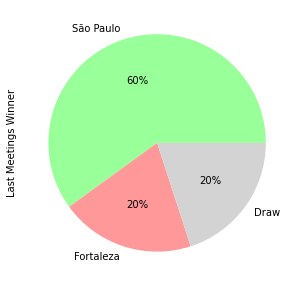

In [8]:
#### Last Games Results/Winner #####

response = requests.get(match_to_predict_url, headers={'User-Agent': 'Custom'})
match_url_content = BeautifulSoup(response.content, 'html.parser')

last_10_meetings_results = []
last_10_meetings_winners = []
last_matches_between_teams_results = 0

try:
    last_meetings = match_url_content.find("div", class_="table-header",
                          text=re.compile('Last')).find_parent("div", class_="box")


    meetings_table_body = last_meetings.find("tbody")
    for match_data in meetings_table_body.findAll("tr"):
        temp = []
        for match_teams in match_data.findAll("td", class_="no-border-links"):
            temp.append(match_teams.find("a").get_text(strip=True))
        for match_result in match_data.findAll("a", title=re.compile("Match ")):       ##("a", title="Match report"):
            temp.append(match_result.get_text(strip=True))
            color = match_result.find("span")["class"]
            if color == ['greentext']:
                last_10_meetings_winners.append(home_team)
                last_matches_between_teams_results += 2
            elif color == ['redtext']:
                last_10_meetings_winners.append(away_team)
                last_matches_between_teams_results -= 2
            elif color == []:
                last_10_meetings_winners.append('Draw')
        last_10_meetings_results.append(tuple(temp))
    

    pie_colors = ['#99ff99', '#ff9999', '#D3D3D3']
    pie_index = [home_team, away_team, 'Draw']

    data = {'Last Meetings Winner':[last_10_meetings_winners.count(home_team),
                                    last_10_meetings_winners.count(away_team),
                                    last_10_meetings_winners.count('Draw')]}
    winners_df = pd.DataFrame(data, index = pie_index)
    display(winners_df['Last Meetings Winner'].plot.pie(autopct='%1.0f%%', figsize=(10, 5), colors=pie_colors)) #autopct=("%d")

except: 
    print("No Past Meetings Data")
    pass


Last matches between teams results:


,São Paulo,Fortaleza
0,2,3
1,10,9on pens
2,3,3
3,1,0
4,2,1
5,0,1
6,1,1
7,1,0
8,1,0
9,3,2


<AxesSubplot:>

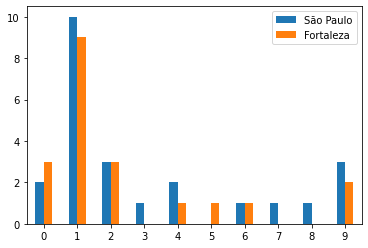

In [9]:
#### Graph Of Last Games Between Teams Results #####

res = [lis[2] for lis in last_10_meetings_results]
print()
home_team_goals = [i.split(':')[0] for i in res] 
away_team_goals = [i.split(':')[1] for i in res] 

a = [re.sub("[^0-9]", "", x) for x in away_team_goals]
h = [re.sub("[^0-9]", "", x) for x in home_team_goals]

print('Last matches between teams results:')
df_resuls = pd.DataFrame({home_team: home_team_goals, away_team: away_team_goals})
display(df_resuls)
print()

ax = pd.DataFrame({home_team: h, away_team: a})

ax = ax.astype(int)
ax = ax.plot.bar(rot=0)
display(ax)


In [10]:
#### Teams Players Value #####

try:
    teams_market_value = []
    
    temp = match_url_content.find("div", class_="box daten-und-fakten")
    home_team_market_value = temp.find("td", class_= "daten-und-fakten-linker_balken").get_text()
    away_team_market_value = temp.find("td", class_= "daten-und-fakten-rechter_balken").get_text()
    
    print(home_team + ' Market Value: ' + home_team_market_value)
    print(away_team + ' Market Value: ' + away_team_market_value)    
    
    final_home_value = float(re.search(r'\d+\.\d+', home_team_market_value).group())
    final_away_value = float(re.search(r'\d+\.\d+', away_team_market_value).group())
    
    if 'm' in home_team_market_value.lower():
        final_home_value *= 1000000 
    elif 'b' in home_team_market_value.lower():
        final_home_value *= 1000000000
    final_home_value = int(final_home_value)
    
    if 'm' in away_team_market_value.lower():
        final_away_value *= 1000000 
        final_away_value = int(final_away_value)
    elif 'b' in away_team_market_value.lower():
        final_away_value *= 1000000000

    values = final_home_value / final_away_value
    
except:
    values = 0
    pass

São Paulo Market Value: 
€78.40m

Fortaleza Market Value: 
€20.85m



In [11]:
#### Teams Position #####

temp = match_url_content.find("div", class_="box sb-spielbericht-head")

home_team_link = temp.find("div", class_="sb-team sb-heim").find("a", class_= "sb-vereinslink", href=True).get('href')
away_team_link = temp.find("div", class_="sb-team sb-gast").find("a", class_= "sb-vereinslink", href=True).get('href')

home_team_url_content = get_url_content(home_team_link)
away_team_url_content = get_url_content(away_team_link)


## Home Team Position ##
try:
    home_team_position = home_team_url_content.find("div", class_="dataZusatzDaten").find("span", class_="dataValue").find("a", title="League table").get_text()
except:
    #print("No Home Team Position Data")
    home_team_position = '-'
    pass


## Home Team Last 15 Matches ####
try:
    slider = home_team_url_content.find("div", class_="c2action-footer bxPagerParent")
    all_fixtures_link = slider.find("a", href=True).get('href')
    all_fixtures_url_content = get_url_content(all_fixtures_link)

    home_team_last_15_matches = []    
    
    l_home=[]
    home_team_results_table = all_fixtures_url_content.find("div", class_="box letzte_spiele hide-for-small").find("div", class_="responsive-table").find("table")
    home_team_table_rows = home_team_results_table.findAll('tr')
    home_team_table_rows_titles = []
    home_team_table_cols = []
    for tr in home_team_table_rows:
        td = tr.findAll('td')
        row = [tr.get_text(strip=True) for tr in td]
        l_home.append(row)
    home_team_index_table = [l_home[0][0], l_home[1][0], l_home[2][0]] 
    home_team_table = pd.DataFrame(l_home, index=home_team_index_table)  #  .iloc[:,1:]
    del home_team_table[home_team_table.columns[0]]
    print(home_team, 'Last 15 Matches (Home Team)')
    print('Position: ', home_team_position)
    print('Market Value: ', home_team_market_value)
    display(home_team_table)

    home_team_table_list = home_team_table.values.tolist()
    
    home_team_H_W_counts = home_team_table_list[0].count('H')
    home_team_H_D_counts = home_team_table_list[1].count('H')
    home_team_H_L_counts = home_team_table_list[2].count('H')
    print('Home W : ', home_team_H_W_counts)
    print('Home D : ', home_team_H_D_counts)
    print('Home L : ', home_team_H_L_counts)

    total_home_games_number = home_team_H_W_counts + home_team_H_D_counts + home_team_H_L_counts
    print('Total Home Games : ',total_home_games_number)
    
    home_team_home_points = (home_team_H_W_counts*2) + (home_team_H_D_counts*1)
    home_team_home_points = home_team_home_points / (total_home_games_number)
except:
    print("No Home Team Last Matches Data")
    pass



## Away Team Position ##
try:
    away_team_position = away_team_url_content.find("div", class_="dataZusatzDaten").find("span", class_="dataValue").find("a", title="League table").get_text()
except:
    away_team_position = '-'
    pass


## Away Team Last 15 Matches ####
try:
    slider = away_team_url_content.find("div", class_="c2action-footer bxPagerParent")
    all_fixtures_link = slider.find("a", href=True).get('href')
    all_fixtures_url_content = get_url_content(all_fixtures_link)

    away_team_last_15_matches = []
        
    l_away=[]
    away_team_results_table = all_fixtures_url_content.find("div", class_="box letzte_spiele hide-for-small").find("div", class_="responsive-table").find("table")
    away_team_table_rows = away_team_results_table.findAll('tr')
    away_team_table_rows_titles = []
    away_team_table_cols = []
    for tr in away_team_table_rows:
        td = tr.findAll('td')
        row = [tr.get_text(strip=True) for tr in td]
        l_away.append(row)
    away_team_index_table = [l_away[0][0], l_away[1][0], l_away[2][0]] 
    away_team_table = pd.DataFrame(l_away, index=away_team_index_table)  #  .iloc[:,1:]
    del away_team_table[away_team_table.columns[0]]
    print('-----------------------------')
    print()
    print(away_team, 'Last 15 Matches (Away Team)')
    print('Position: ', away_team_position)
    print('Market Value: ', away_team_market_value)
    display(away_team_table)
    
    away_team_table_list = away_team_table.values.tolist()
    
    away_team_A_W_counts = away_team_table_list[0].count('A')
    away_team_A_D_counts = away_team_table_list[1].count('A')
    away_team_A_L_counts = away_team_table_list[2].count('A')
    print('Away W : ', away_team_A_W_counts)
    print('Away D : ', away_team_A_D_counts)
    print('Away L : ', away_team_A_L_counts)
    
    total_away_games_number = away_team_A_W_counts + away_team_A_D_counts + away_team_A_L_counts
    print('Total Away Games : ',total_away_games_number)
    
    away_team_away_points = (away_team_A_W_counts*2) + (away_team_A_D_counts*1)
    away_team_away_points = away_team_away_points / (total_away_games_number)
except:
    print("No Away Team Last Matches Data")
    pass

São Paulo Last 15 Matches (Home Team)
Position:  14
Market Value:  
€78.40m



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
W,H,,,,H,,,,,,,,A,H,
D,,H,,,,,H,,H,A,A,,,,H
L,,,A,A,,A,,A,,,,H,,,


Home W :  3
Home D :  4
Home L :  1
Total Home Games :  8
-----------------------------

Fortaleza Last 15 Matches (Away Team)
Position:  4
Market Value:  
€20.85m



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
W,H,,A,,H,A,H,,,,,H,,H,H
D,,H,,H,,,,A,H,,A,,,,
L,,,,,,,,,,A,,,A,,


Away W :  2
Away D :  2
Away L :  2
Total Away Games :  6


In [12]:
# Data need to insert to the model to predict:
#
# 1. Teams Values
# 2. Teams Positions
# 3. Last Each Team Games Results
# 4. Last Games Between Teams Results

### df columns building ###

df_match_to_predict = []

if home_team_position == '-' or away_team_position == '-':
    positions = 0
else:
    positions = int(away_team_position) - int(home_team_position)

last_each_team_results = home_team_home_points - away_team_away_points

df_match_to_predict.append(tuple([values, positions, last_each_team_results, last_matches_between_teams_results]))

In [13]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#printmd('*BOLD TEXT*')
#printmd('**BOLD TEXT**')
#printmd('***BOLD TEXT***')

%store -r chosen_model
print()
printmd('**Match:** ' + '**'+home_team+'**' + ' **vs** ' + '**'+away_team+'**')
result_predict = chosen_model.predict(df_match_to_predict)[0]
if result_predict == 2:
    printmd('***The Predict Winner Is: '+home_team+'***')
elif result_predict == 0:
    printmd('***The Predict Winner Is: '+away_team+'***')
else: 
    printmd('***The Predict Result Is Draw***')
    
file = open("Images/Ball.jpg", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=500,
    height=100,
)

**Match:** **São Paulo** **vs** **Fortaleza**

***The Predict Winner Is: São Paulo***

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x02\x1cICC_PROFILE\x00\x0…